In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

In [11]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [12]:
# descr : describing the dataset
# data : containing an array with one row per instance and one column per feature
# target : an array with the labels

In [13]:
X, y = mnist["data"], mnist["target"]

In [14]:
X.shape

(70000, 784)

In [15]:
y.shape

(70000,)

In [16]:
# 70,000 images, each image has 784 features (28 * 28 pixels)

그림 저장: some_digit_plot


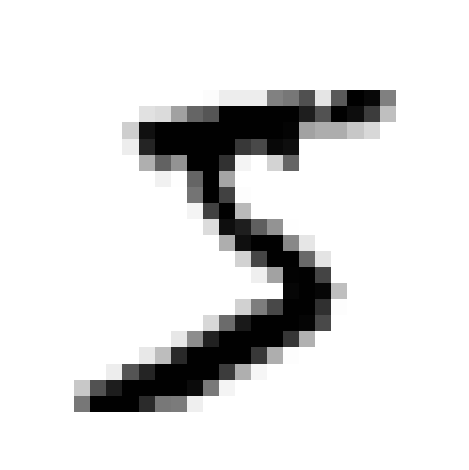

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [18]:
y[0]

'5'

In [19]:
# cast y to intergers(from string)
y = y.astype(np.uint8)

In [20]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [23]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row) 
    n_rows = (len(instances) - 1) // images_per_row + 1 
    #n_rows = ceil(len(instances) / images_per_row)와 동일
    
    # 그리드 끝을 채우기 위해 빈 이미지 추가
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    # 배열의 크기를 바꾸어서 28 * 28 이미지를 담은 그리드로 구성
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    # 축 0(이미지 그리드의 수직축) 과 2(이미지의 수직축)를 합치고 축 1과3(두 수평축)을 합친다.
    # 먼저 tranpose()를 사용해서 결합하려는 축을 옆으로 이동한 다음 합친다
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    # 하나의 큰 이미지를 출력
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


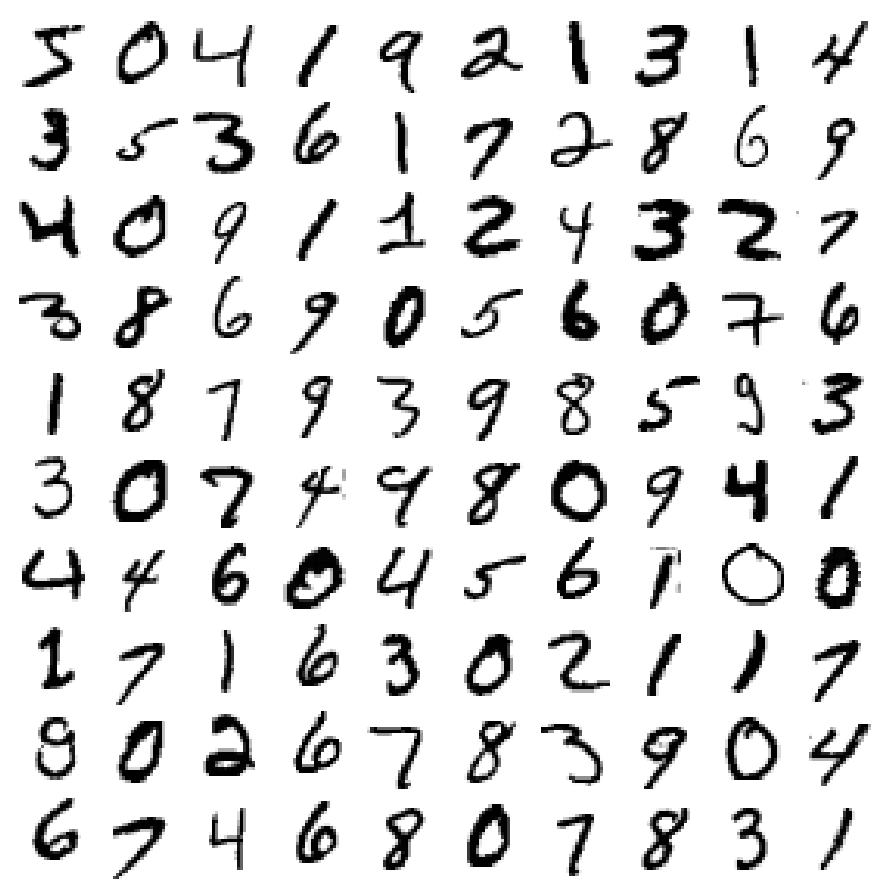

In [24]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [26]:
# train test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier

In [28]:
# True : 5, False : not 5 
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

In [31]:
# Stochastic Gradient Descent Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [32]:
sgd_clf.predict([some_digit]) # some_digit : 5

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [38]:
# cross_val_score()

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [37]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [39]:
# not 5 class  
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [41]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [43]:
# actual non 5 image correctly classified as non 5s (true negatives) :  53892
# actual non 5 image wrongly classified as 5s (false positives) : 687
# actual 5 image wrongly classified as non 5s (false negatives) : 1891
# actual 5 image correctly classified as 5s (true positives) : 3530

In [44]:
y_train_perfect_predictions = y_train_5 # pretend to perfect
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [45]:
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)

In [48]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 3530 / 3530 + 687

0.8370879772350012

In [49]:
recall_score(y_train_5, y_train_pred) # 3530 / 3530 + 1891

0.6511713705958311

In [52]:
3530 / (3530 + 687)

0.8370879772350012

In [53]:
3530 / (3530 + 1891)

0.6511713705958311

In [54]:
# f1 score = TP / (TP + ((FN + FP) / 2))

In [55]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) # 3530 / (3530 + ((1891 + 687) / 2))

0.7325171197343846

In [56]:
3530 / (3530 + ((1891 + 687) / 2))

0.7325171197343847

### Prcision/Recall Tradeoff

In [57]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [62]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [63]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [64]:
# threshold is 0, the classifier detects it
# threshold is 8000, the classifier misses it

In [65]:
# need to get the scores of all instances in the training set using cross_val_predict()
# need to returen decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [67]:
# compute precision and recall for all possible thresholds using the precision_recall_curve()
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

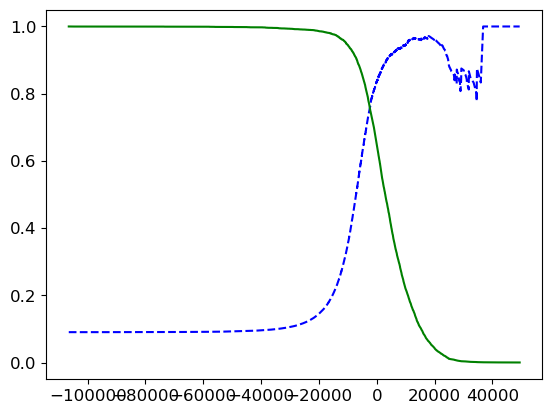

In [68]:
# plot precision and recall as functions of the threshold value using Matplotlib
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

그림 저장: precision_recall_vs_threshold_plot


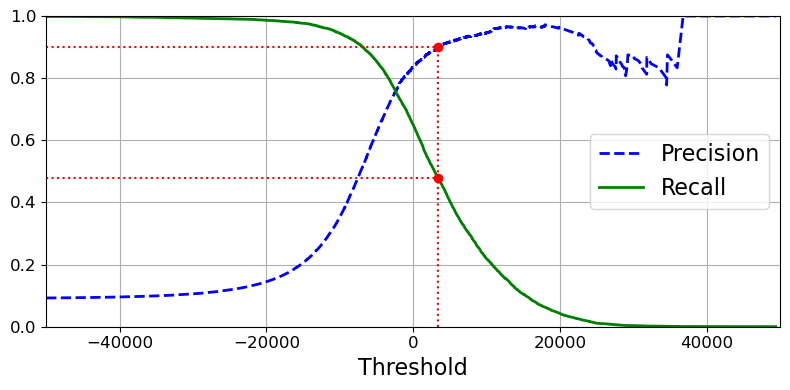

In [69]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [71]:
(y_train_pred == (y_scores > 0)).all()

True

그림 저장: precision_vs_recall_plot


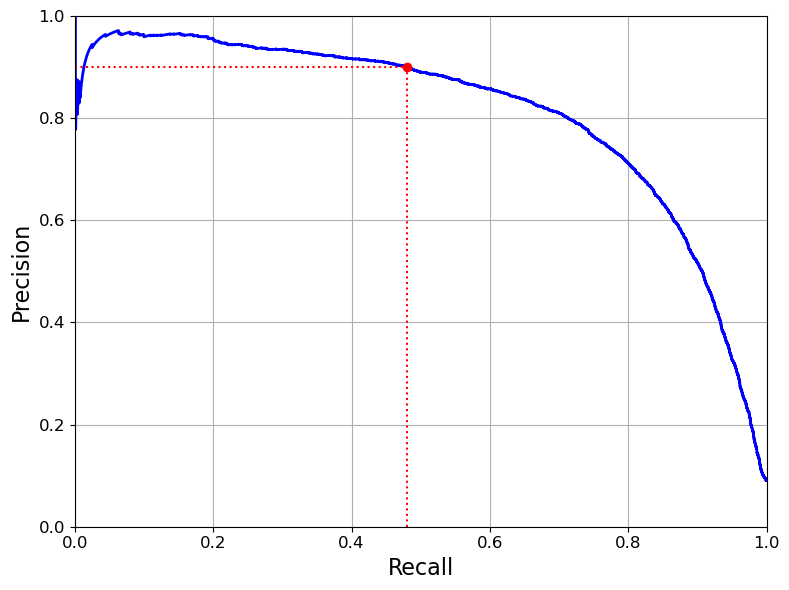

In [72]:
# plot precision directly against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [74]:
# if decide to aim 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439566

In [75]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [76]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve